In [1092]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [1093]:
def draw(circuit, params=None, **kwargs):
    fig, _ = qml.draw_mpl(circuit, **kwargs)(params)
    fig.show()

def to_bitstring(x):
    return ''.join([str(i) for i in x])

### Define the Hamiltonian and Unitaries

In [1094]:
# Cost Hamiltonian
def Hc(u, v):
    return 0.5 * (1 - qml.PauliZ(u) @ qml.PauliZ(v))

# Cost Unitary
def Uc(gamma):
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * gamma, wires=1)
    qml.CNOT(wires=[0, 1])

# Mixer Unitary
def Um(beta):
    qml.RX(2 * beta, wires=0)
    qml.RX(2 * beta, wires=1)

### The QAOA Ansatz

In [1095]:
def QAOA(gamma, beta):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    
    Uc(gamma)
    
    Um(beta)

### Define the Circuit

In [1096]:
dev = qml.device("default.qubit", wires=2, shots=100)

qc = qml.device('')

### Theoretical

In [1097]:
# For optimising the circuit
@qml.qnode(dev)
def circuit_analytical(params):
    gamma, beta = params
    
    QAOA(gamma, beta)
    
    return qml.expval(Hc(0, 1))

# For sampling from the circuit
@qml.qnode(dev)
def measure_analytical(params):
    gamma, beta = params
    
    QAOA(gamma, beta)
    
    return qml.probs(wires=[0, 1])

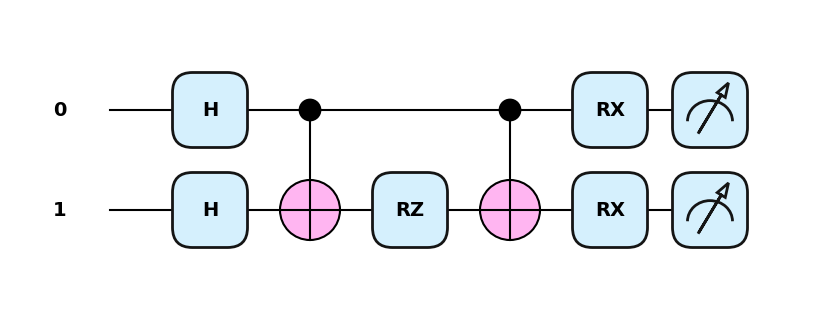

In [1098]:
draw(circuit, np.array([1, 1]), style='pennylane')

## Optimising the Parameters

In [1099]:
def QAOA_maxcut(cost, params, steps = 100, optimiser = None, log=False):
    if not optimiser:
        optimiser = qml.AdamOptimizer(stepsize=0.1)
    
    loss = []

    # Iteratively Optimise
    for i in range(steps):
        params = optimiser.step(lambda x: -cost(x), params)
        loss.append(cost(params))
        
        if (i + 1) % 10 == 0 and log:
            print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

    if log: print("Optimized rotation angles: {}".format(params))
    
    return loss, params

In [1100]:
init_params = 0.1 * np.random.rand(2, requires_grad=True)

loss, params = QAOA_maxcut(circuit, init_params)

print(f'Gamma = {params[0]}\nBeta = {params[1]}')

Gamma = 0.7721623759911518
Beta = 0.40842928457541583


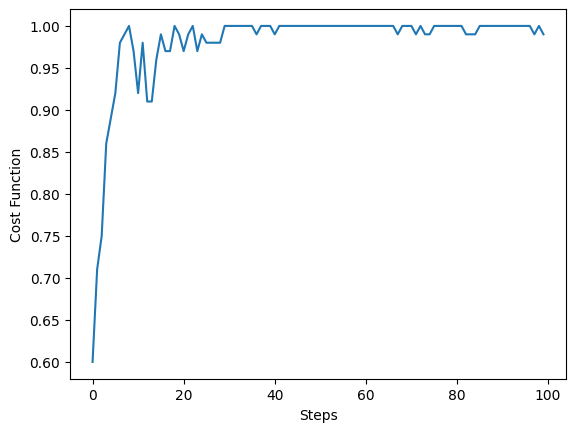

In [1101]:
plt.plot(loss)
plt.ylabel('Cost Function')
plt.xlabel('Steps')
plt.show()

In [1102]:
measure(params)

array([0.  , 0.46, 0.54, 0.  ])

In [1103]:
# observations = measure(params)

# data = [to_bitstring(obs) for obs in observations]

In [1104]:
# plt.hist(data)
# plt.show()